# Comparing Explainability Methods Under a White Box Model
This is a "fluorescent test," conducted under laboratory conditions with fluorescent lighting. In this test, we will generate synthetic data with known dynamics for the response variable. Next, we will calculate global explanations using various explainability methods and compare them against the ground truth.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

from explainer_comparison.ExplainerFactory import ExplainerFactory
from explainer_comparison.explainer_utilities import run_and_collect_explanations
from explainer_comparison.white_box_model.white_box import WhiteBoxRegressor
from explainer_comparison.explainers_evaluation import evaluate_explainers, permutation_feature_importance, plot_feat_importance, evaluate_mse, plot_mse


import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [2]:
# import sys
# sys.path

## Generate a White-Box Model and Data

In [3]:
# model = WhiteBoxRegressor()
# df = model.generate_synthetic_data(n_samples=1000, with_y=True)
# X, y = df.drop(['y'], axis=1), df[['y']]

In [4]:
n_samples = 1000
n_features = 10
feature_columns = [f'f_{i+1}' for i in range(n_features)]

X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_features, noise=0, random_state=42)
X = pd.DataFrame(X, columns=feature_columns)
y = pd.DataFrame(y, columns=['target'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Visualize Features and Target

<Axes: >

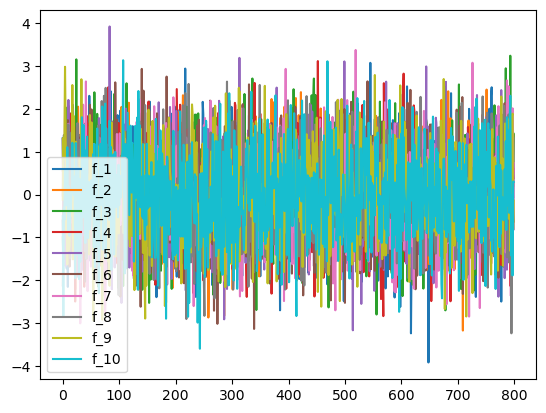

In [7]:
X_train.plot()

<Axes: >

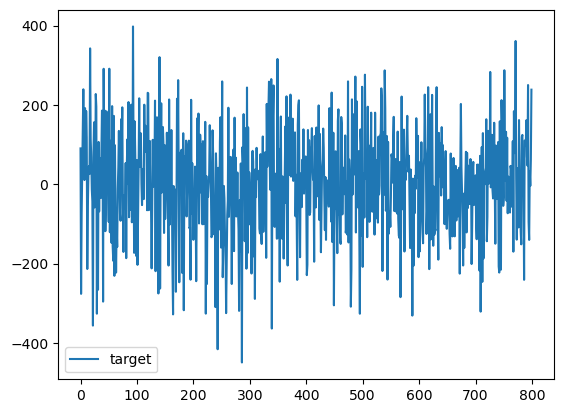

In [8]:
y_train.plot()

## Calculate SHAP and LIME explanation and Compare to Ground Truth

In [9]:
explainer_factory = ExplainerFactory(model, X_train, X_test, y_train, y_test)
results = run_and_collect_explanations(explainer_factory, X_train)
results['ground_truth'] = (X_train * model.coef_).mean()


 SHAP explanation created

 LIME explanation created

 EBM explanation created


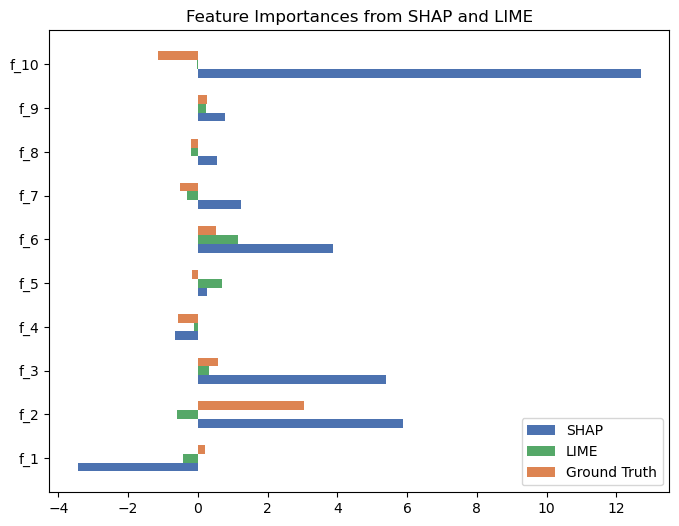

In [10]:
colors = sns.color_palette("deep")
plt.figure(figsize=(8, 6))

bar_positions = np.arange(len(results))  # Positions of the bars
bar_width = 0.2  # Adjust bar width to fit all bars

# Plotting the bars with adjusted positions
plt.barh(bar_positions - bar_width, results['SHAP Value'], height=bar_width, label='SHAP', color=colors[0])  # SHAP values
plt.barh(bar_positions, results['LIME Value'], height=bar_width, label='LIME', color=colors[2])  # LIME values
plt.barh(bar_positions + bar_width, results['ground_truth'], height=bar_width, label='Ground Truth', color=colors[1])  # Ground Truth values

plt.yticks(bar_positions, results.index)  #labels

plt.title('Feature Importances from SHAP and LIME')
plt.legend()
plt.show()

## Calculate permutation feature importance

In [11]:
feature_importances = permutation_feature_importance(model, X_test, y_test, metric='mse', random_state=42)

feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

feature_importances_df

,importance
f_5,-69.031294
f_8,-99.019503
f_4,-187.435442
f_9,-244.919762
f_7,-1666.905291
f_1,-2257.143012
f_3,-2464.930730
f_6,-7764.311483
f_2,-11996.703313
f_10,-13701.157447


## Evaluate the consistency of explainers

In [12]:
results = evaluate_explainers(model, X_test, y_test, metric='mse', threshold=0.3, random_state=42, verbose=False, explainers=['shap', 'lime', 'ebm'])

The least_important_feature is f_5


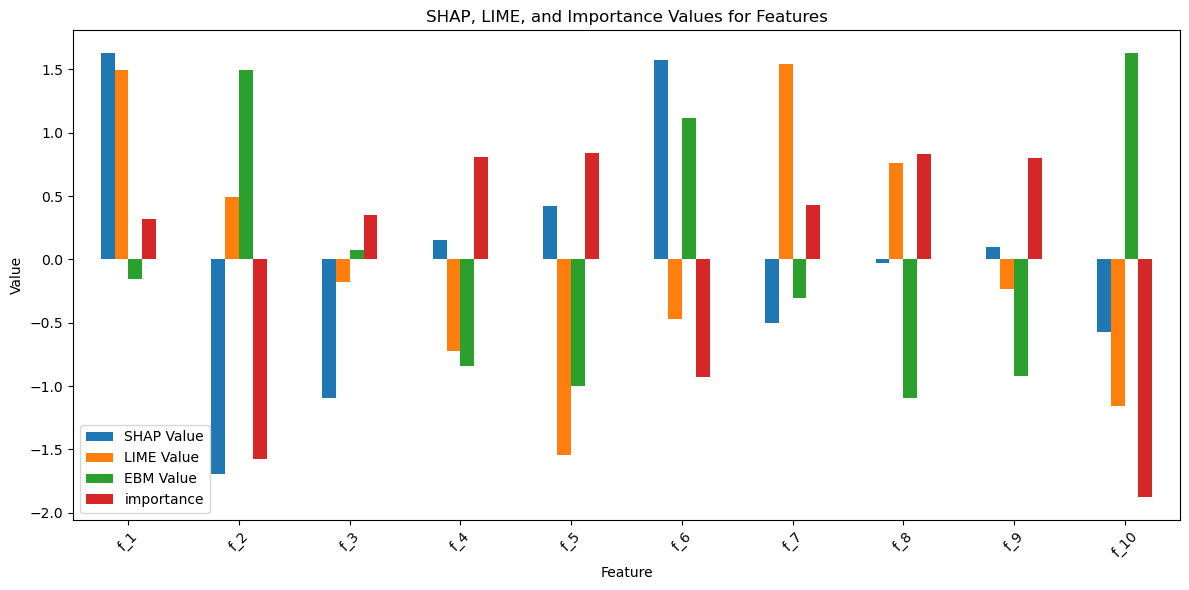

The least_important_feature is f_8


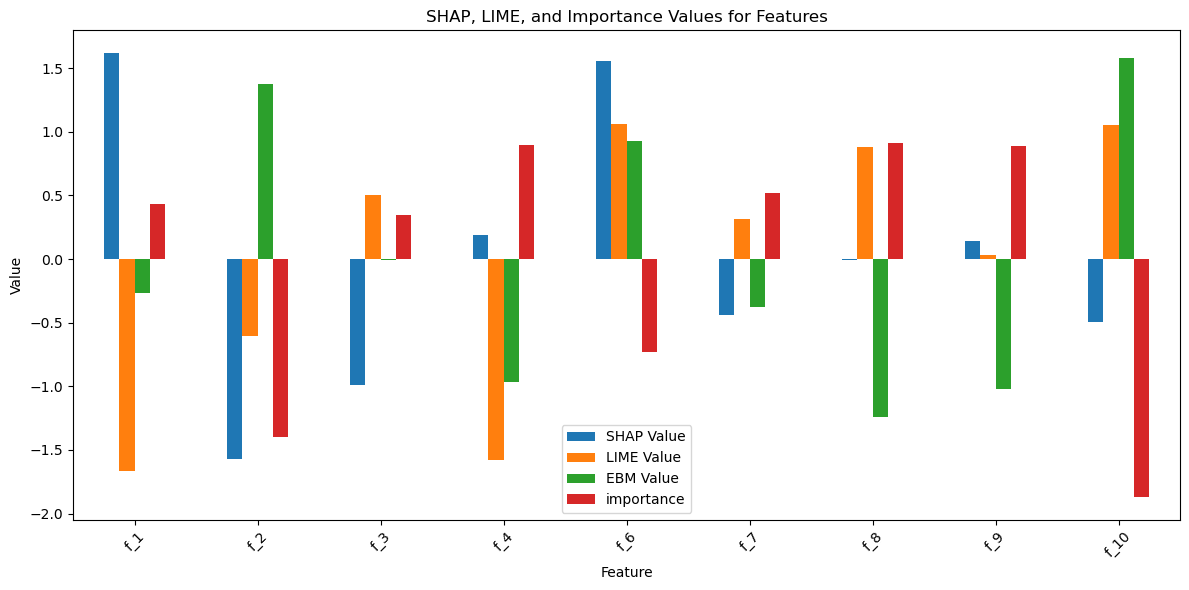

The least_important_feature is f_4


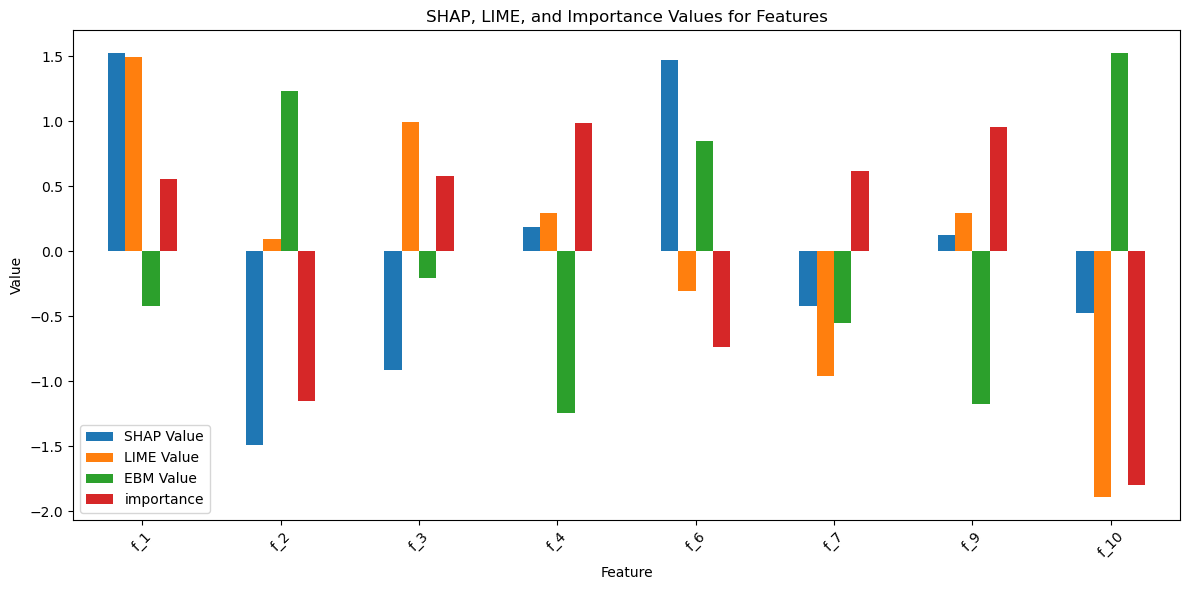

The least_important_feature is f_9


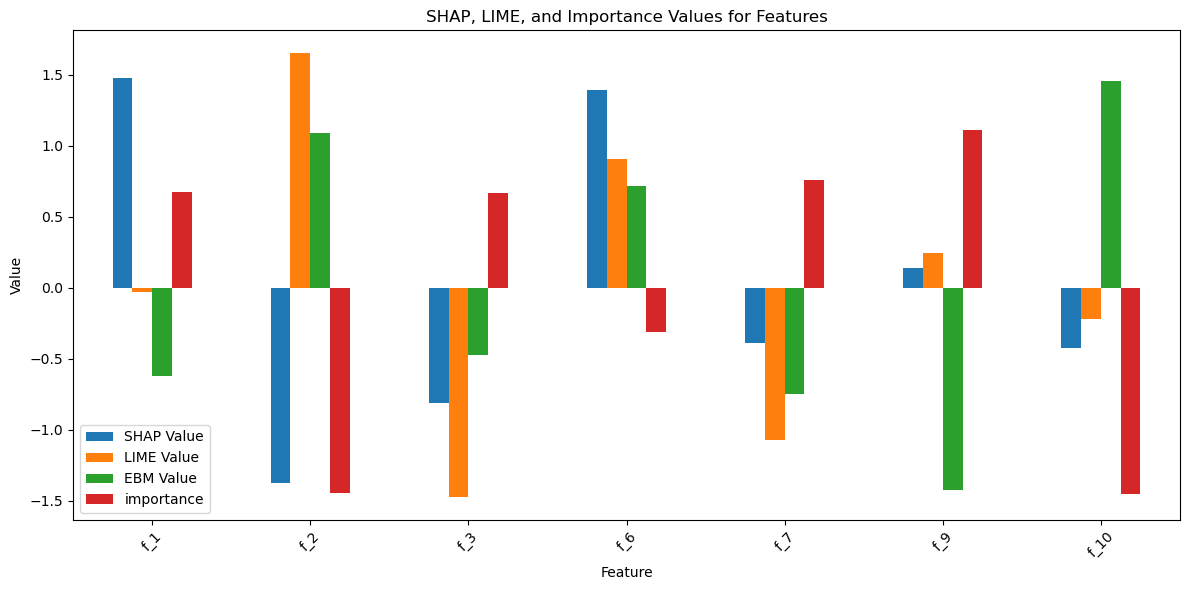

The least_important_feature is f_7


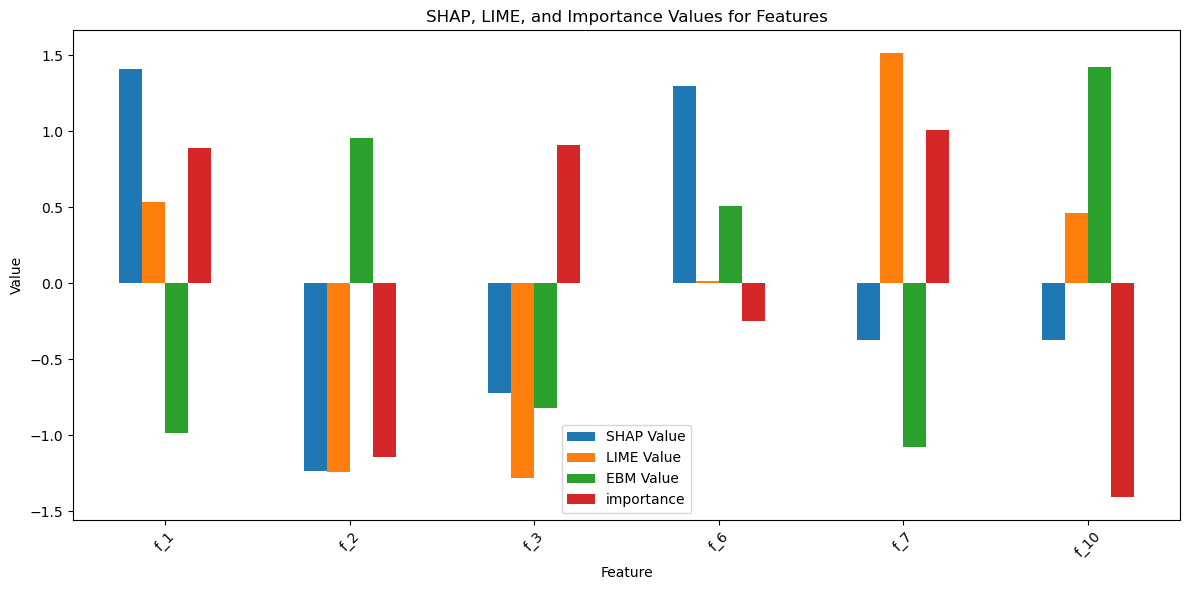

The least_important_feature is f_3


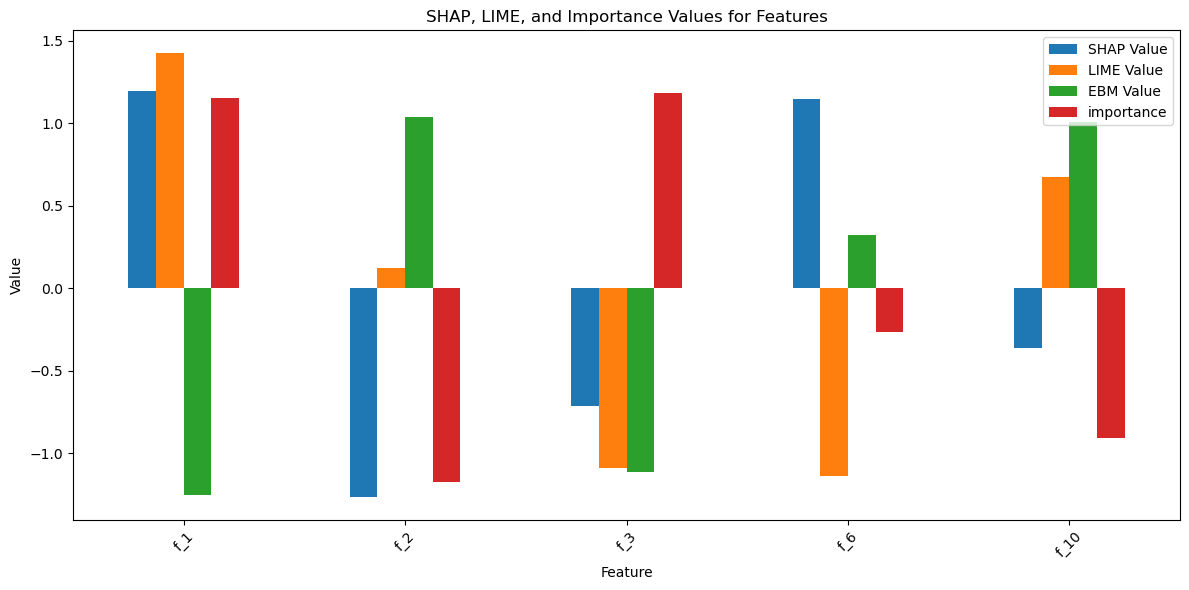

The least_important_feature is f_1


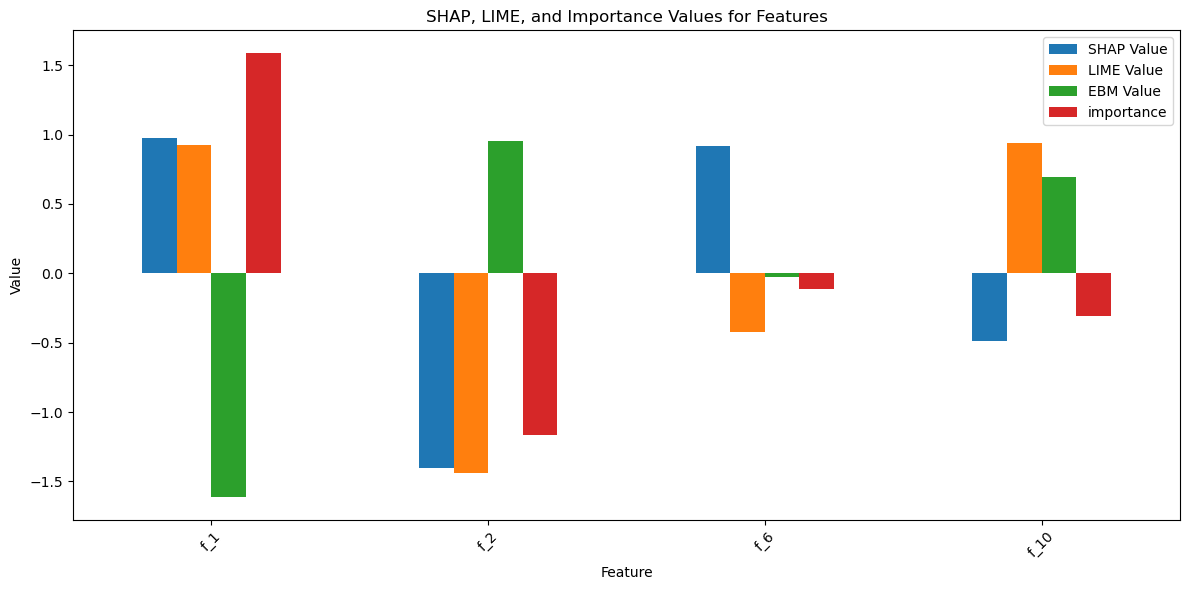

In [13]:
for rdf in results:
    plot_feat_importance(rdf)

In [14]:
# calculate mse for each explainer
mse_dict = evaluate_mse(results)

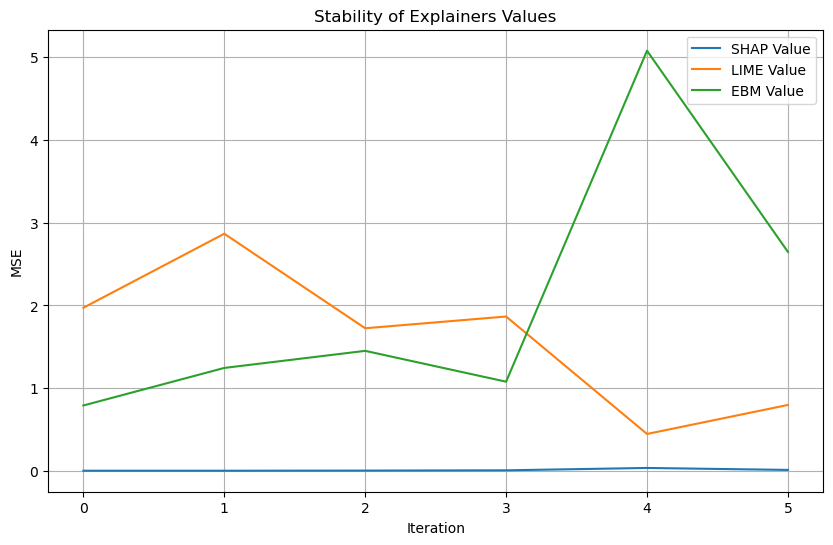

In [15]:
plot_mse(mse_dict)
